In [4]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os
import pandas as pd

In [5]:
def extract_dominant_colors_preprocessed(image_path, k=3):
    """Extract dominant colors from a preprocessed image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    image = cv2.resize(image, (224, 224))
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab_image.reshape(-1, 3).astype(np.float32)
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_


In [6]:
def reconstruct_image(image_path, dominant_colors, k=3):
    """Reconstruct an image using dominant colors."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    image = cv2.resize(image, (224, 224))
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab_image.reshape(-1, 3)
    
    distances = np.linalg.norm(pixels[:, np.newaxis] - dominant_colors, axis=2)
    labels = np.argmin(distances, axis=1)
    reconstructed_pixels = dominant_colors[labels]
    
    reconstructed_image = reconstructed_pixels.reshape(lab_image.shape)
    return cv2.cvtColor(reconstructed_image.astype(np.uint8), cv2.COLOR_LAB2BGR)


In [7]:
def calculate_mse(original_image, reconstructed_image):
    """Calculate Mean Squared Error (MSE)."""
    if original_image.shape != reconstructed_image.shape:
        reconstructed_image = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
    return np.mean((original_image.astype(float) - reconstructed_image.astype(float)) ** 2)

def calculate_ssim(original_image, reconstructed_image):
    """Calculate Structural Similarity Index (SSIM)."""
    if original_image.shape != reconstructed_image.shape:
        reconstructed_image = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
    
    if len(original_image.shape) == 3:
        original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        reconstructed_gray = cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original_image
        reconstructed_gray = reconstructed_image
        
    return ssim(original_gray, reconstructed_gray, 
               data_range=reconstructed_gray.max() - reconstructed_gray.min())

In [ ]:
# def calculate_ssim(original_image, reconstructed_image):
#     """
#     Calculate Structural Similarity Index (SSIM) between two images.
    
#     Parameters:
#         original_image (np.ndarray): Original image.
#         reconstructed_image (np.ndarray): Reconstructed image.
    
#     Returns:
#         float: SSIM value.
#     """
#     if original_image.shape != reconstructed_image.shape:
#         reconstructed_image = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
    
#     # Convert to grayscale if needed
#     if len(original_image.shape) == 3:
#         original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
#         reconstructed_gray = cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2GRAY)
#     else:
#         original_gray = original_image
#         reconstructed_gray = reconstructed_image
        
#     return ssim(original_gray, reconstructed_gray, 
#                data_range=reconstructed_gray.max() - reconstructed_gray.min())

In [8]:
def find_optimal_k(image_path, max_k=10):
    """Find optimal k using the Elbow Method."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    image = cv2.resize(image, (224, 224))
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab_image.reshape(-1, 3).astype(np.float32)
    
    inertia_values = []
    k_values = range(1, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pixels)
        inertia_values.append(kmeans.inertia_)
    
    diff = np.diff(inertia_values)
    diff_r = diff[1:] / diff[:-1]
    optimal_k = np.argmin(diff_r) + 2  # Adding 2 due to diff operations
    return min(optimal_k, max_k)

In [9]:
def process_images_in_folder(folder_path, k=None, max_k=10, output_csv="metrics.csv"):
    """
    Process all images in a folder, compute metrics, and save results.
    Shows progress (number of images processed).
    """
    if not os.path.isdir(folder_path):
        raise ValueError(f"Directory {folder_path} does not exist.")
    
    metrics = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_images = len(image_files)
    
    print(f"\nFound {total_images} images. Processing...\n")
    
    for idx, filename in enumerate(sorted(image_files), 1):
        image_path = os.path.join(folder_path, filename)
        try:
            print(f"\nProcessing image {idx}/{total_images}: {filename}")
            
            # Determine optimal k if not provided
            current_k = k
            if k is None:
                current_k = find_optimal_k(image_path, max_k=max_k)
                print(f"Optimal k determined: {current_k}")
            
            # Extract dominant colors and reconstruct
            dominant_colors = extract_dominant_colors_preprocessed(image_path, k=current_k)
            reconstructed_image = reconstruct_image(image_path, dominant_colors, k=current_k)
            
            # Load original image for metrics
            original_image = cv2.imread(image_path)
            
            # Calculate metrics
            mse = calculate_mse(original_image, reconstructed_image)
            ssim_value = calculate_ssim(original_image, reconstructed_image)
            
            metrics.append({
                "filename": filename,
                "k": current_k,
                "mse": mse,
                "ssim": ssim_value,
                "dominant_colors": dominant_colors.tolist()
            })
            
            # Optional: Display first 3 images
            if idx <= 3:
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Reconstructed (k={current_k})")
                plt.axis('off')
                plt.show()
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Save metrics to CSV
    df = pd.DataFrame(metrics)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Processed {len(metrics)}/{total_images} images successfully.")
    print(f"Metrics saved to {output_csv}")
    return df


Found 8357 images. Processing...


Processing image 1/8357: synthetic_10BG_1.0_1.png
Optimal k determined: 2


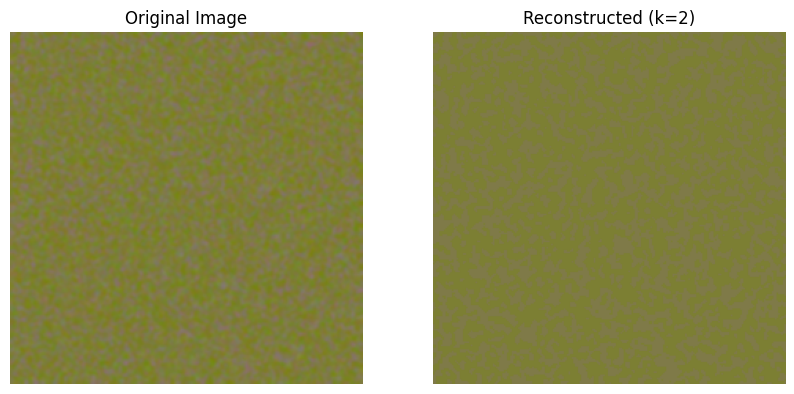


Processing image 2/8357: synthetic_10BG_1.0_2.png
Optimal k determined: 2


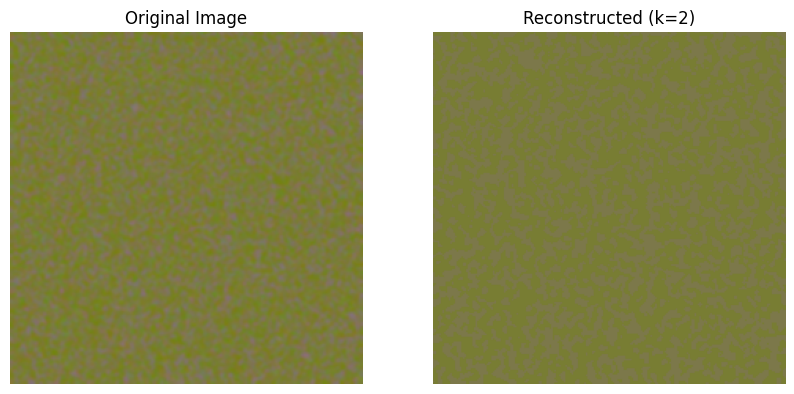


Processing image 3/8357: synthetic_10BG_1.0_3.png
Optimal k determined: 2


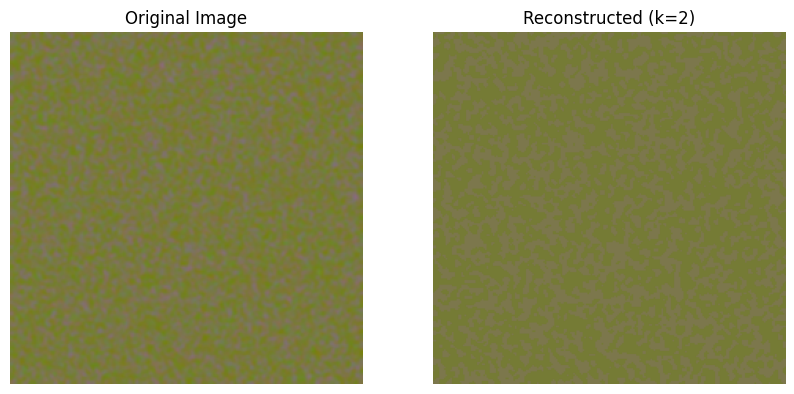


Processing image 4/8357: synthetic_10BG_1.0_4.png
Optimal k determined: 2

Processing image 5/8357: synthetic_10BG_1.0_5.png
Optimal k determined: 2

Processing image 6/8357: synthetic_10BG_1.0_6.png
Optimal k determined: 2

Processing image 7/8357: synthetic_10BG_1.0_7.png
Optimal k determined: 2

Processing image 8/8357: synthetic_10BG_1.0_8.png
Optimal k determined: 2

Processing image 9/8357: synthetic_10BG_10.0_10.png
Optimal k determined: 2

Processing image 10/8357: synthetic_10BG_10.0_12.png
Optimal k determined: 2

Processing image 11/8357: synthetic_10BG_10.0_2.png
Optimal k determined: 2

Processing image 12/8357: synthetic_10BG_10.0_3.png
Optimal k determined: 2

Processing image 13/8357: synthetic_10BG_10.0_4.png
Optimal k determined: 2

Processing image 14/8357: synthetic_10BG_10.0_5.png
Optimal k determined: 2

Processing image 15/8357: synthetic_10BG_10.0_6.png
Optimal k determined: 2

Processing image 16/8357: synthetic_10BG_10.0_7.png
Optimal k determined: 2

Process

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 1353/8357: synthetic_10P_7.0_26.png
Optimal k determined: 2

Processing image 1354/8357: synthetic_10P_7.0_27.png
Optimal k determined: 2

Processing image 1355/8357: synthetic_10P_7.0_29.png
Optimal k determined: 2

Processing image 1356/8357: synthetic_10P_7.0_3.png
Optimal k determined: 2

Processing image 1357/8357: synthetic_10P_7.0_30.png
Optimal k determined: 2

Processing image 1358/8357: synthetic_10P_7.0_4.png
Optimal k determined: 2

Processing image 1359/8357: synthetic_10P_7.0_6.png
Optimal k determined: 2

Processing image 1360/8357: synthetic_10P_7.0_7.png
Optimal k determined: 2

Processing image 1361/8357: synthetic_10P_7.0_8.png
Optimal k determined: 2

Processing image 1362/8357: synthetic_10P_7.0_9.png
Optimal k determined: 2

Processing image 1363/8357: synthetic_10P_8.0_1.png
Optimal k determined: 2

Processing image 1364/8357: synthetic_10P_8.0_10.png
Optimal k determined: 2

Processing image 1365/8357: synthetic_10P_8.0_

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 4721/8357: synthetic_5G_10.0_13.png
Optimal k determined: 2

Processing image 4722/8357: synthetic_5G_10.0_14.png
Optimal k determined: 2

Processing image 4723/8357: synthetic_5G_10.0_15.png
Optimal k determined: 2

Processing image 4724/8357: synthetic_5G_10.0_16.png
Optimal k determined: 2

Processing image 4725/8357: synthetic_5G_10.0_17.png
Optimal k determined: 2

Processing image 4726/8357: synthetic_5G_10.0_18.png
Optimal k determined: 2

Processing image 4727/8357: synthetic_5G_10.0_2.png
Optimal k determined: 2

Processing image 4728/8357: synthetic_5G_10.0_3.png
Optimal k determined: 2

Processing image 4729/8357: synthetic_5G_10.0_5.png
Optimal k determined: 2

Processing image 4730/8357: synthetic_5G_10.0_6.png
Optimal k determined: 2

Processing image 4731/8357: synthetic_5G_10.0_7.png
Optimal k determined: 2

Processing image 4732/8357: synthetic_5G_10.0_8.png
Optimal k determined: 2

Processing image 4733/8357: synthetic_5G_10.0

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5041/8357: synthetic_5PB_2.0_43.png


/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5042/8357: synthetic_5PB_2.0_44.png
Optimal k determined: 2

Processing image 5043/8357: synthetic_5PB_2.0_45.png


/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: divide by zero encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5044/8357: synthetic_5PB_2.0_6.png


/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: divide by zero encountered in divide
  S = (A1 * A2) / D
/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5045/8357: synthetic_5PB_2.0_7.png
Optimal k determined: 2

Processing image 5046/8357: synthetic_5PB_2.0_8.png
Optimal k determined: 2

Processing image 5047/8357: synthetic_5PB_2.0_9.png
Optimal k determined: 2

Processing image 5048/8357: synthetic_5PB_2.5_1.png
Optimal k determined: 2

Processing image 5049/8357: synthetic_5PB_2.5_10.png
Optimal k determined: 2

Processing image 5050/8357: synthetic_5PB_2.5_11.png
Optimal k determined: 2

Processing image 5051/8357: synthetic_5PB_2.5_12.png
Optimal k determined: 2

Processing image 5052/8357: synthetic_5PB_2.5_14.png
Optimal k determined: 2

Processing image 5053/8357: synthetic_5PB_2.5_15.png
Optimal k determined: 2

Processing image 5054/8357: synthetic_5PB_2.5_16.png
Optimal k determined: 2

Processing image 5055/8357: synthetic_5PB_2.5_17.png
Optimal k determined: 2

Processing image 5056/8357: synthetic_5PB_2.5_19.png
Optimal k determined: 2

Processing image 5057/8357: synthetic_5PB_2

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: divide by zero encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5072/8357: synthetic_5PB_2.5_40.png
Optimal k determined: 2

Processing image 5073/8357: synthetic_5PB_2.5_41.png
Optimal k determined: 2

Processing image 5074/8357: synthetic_5PB_2.5_42.png
Optimal k determined: 2

Processing image 5075/8357: synthetic_5PB_2.5_44.png
Optimal k determined: 2

Processing image 5076/8357: synthetic_5PB_2.5_45.png
Optimal k determined: 2

Processing image 5077/8357: synthetic_5PB_2.5_5.png
Optimal k determined: 2

Processing image 5078/8357: synthetic_5PB_2.5_6.png
Optimal k determined: 2

Processing image 5079/8357: synthetic_5PB_2.5_7.png
Optimal k determined: 2

Processing image 5080/8357: synthetic_5PB_2.5_8.png
Optimal k determined: 2

Processing image 5081/8357: synthetic_5PB_2.5_9.png
Optimal k determined: 2

Processing image 5082/8357: synthetic_5PB_3.0_1.png
Optimal k determined: 2

Processing image 5083/8357: synthetic_5PB_3.0_10.png
Optimal k determined: 2

Processing image 5084/8357: synthetic_5PB_3.0

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: divide by zero encountered in divide
  S = (A1 * A2) / D
/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 5119/8357: synthetic_5PB_3.0_6.png
Optimal k determined: 2

Processing image 5120/8357: synthetic_5PB_3.0_7.png
Optimal k determined: 2

Processing image 5121/8357: synthetic_5PB_3.0_8.png
Optimal k determined: 2

Processing image 5122/8357: synthetic_5PB_4.0_1.png
Optimal k determined: 2

Processing image 5123/8357: synthetic_5PB_4.0_10.png
Optimal k determined: 2

Processing image 5124/8357: synthetic_5PB_4.0_12.png
Optimal k determined: 2

Processing image 5125/8357: synthetic_5PB_4.0_14.png
Optimal k determined: 2

Processing image 5126/8357: synthetic_5PB_4.0_15.png
Optimal k determined: 2

Processing image 5127/8357: synthetic_5PB_4.0_16.png
Optimal k determined: 2

Processing image 5128/8357: synthetic_5PB_4.0_17.png
Optimal k determined: 2

Processing image 5129/8357: synthetic_5PB_4.0_18.png
Optimal k determined: 2

Processing image 5130/8357: synthetic_5PB_4.0_19.png
Optimal k determined: 2

Processing image 5131/8357: synthetic_5PB_4

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 7314/8357: synthetic_7.5PB_5.0_3.png
Optimal k determined: 2

Processing image 7315/8357: synthetic_7.5PB_5.0_30.png
Optimal k determined: 2

Processing image 7316/8357: synthetic_7.5PB_5.0_31.png
Optimal k determined: 2

Processing image 7317/8357: synthetic_7.5PB_5.0_32.png
Optimal k determined: 2

Processing image 7318/8357: synthetic_7.5PB_5.0_33.png
Optimal k determined: 2

Processing image 7319/8357: synthetic_7.5PB_5.0_34.png
Optimal k determined: 2

Processing image 7320/8357: synthetic_7.5PB_5.0_6.png
Optimal k determined: 2

Processing image 7321/8357: synthetic_7.5PB_5.0_7.png
Optimal k determined: 2

Processing image 7322/8357: synthetic_7.5PB_5.0_8.png
Optimal k determined: 2

Processing image 7323/8357: synthetic_7.5PB_5.0_9.png
Optimal k determined: 2

Processing image 7324/8357: synthetic_7.5PB_6.0_10.png
Optimal k determined: 2

Processing image 7325/8357: synthetic_7.5PB_6.0_11.png
Optimal k determined: 2

Processing image 732

/home/sala/miniconda3/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


Optimal k determined: 2

Processing image 8000/8357: synthetic_7.5R_7.0_26.png
Optimal k determined: 2

Processing image 8001/8357: synthetic_7.5R_7.0_3.png
Optimal k determined: 2

Processing image 8002/8357: synthetic_7.5R_7.0_4.png
Optimal k determined: 2

Processing image 8003/8357: synthetic_7.5R_7.0_6.png
Optimal k determined: 2

Processing image 8004/8357: synthetic_7.5R_7.0_9.png
Optimal k determined: 2

Processing image 8005/8357: synthetic_7.5R_8.0_1.png
Optimal k determined: 2

Processing image 8006/8357: synthetic_7.5R_8.0_12.png
Optimal k determined: 2

Processing image 8007/8357: synthetic_7.5R_8.0_14.png
Optimal k determined: 2

Processing image 8008/8357: synthetic_7.5R_8.0_15.png
Optimal k determined: 2

Processing image 8009/8357: synthetic_7.5R_8.0_16.png
Optimal k determined: 2

Processing image 8010/8357: synthetic_7.5R_8.0_18.png
Optimal k determined: 2

Processing image 8011/8357: synthetic_7.5R_8.0_19.png
Optimal k determined: 2

Processing image 8012/8357: synt

In [10]:
if __name__ == "__main__":
    image_folder = "/home/sala/data/organized_data/preprocessed_train"
    process_images_in_folder(image_folder, k=None, max_k=10, output_csv="color_metrics.csv")